In [287]:
import pandas as pd
import numpy as np
import random
import keras
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot
import seaborn

%matplotlib inline

In [288]:
#Variáveis de treinamento
num_epochs = 1000
train_batch_size = 32
verbosity = 1
validation_split_ratio = 0.2
target = 'inadimplente'
optimizer_name = 'adam' # 'sgd', 'adam', 'rmsprop'
learning_rate_defined = 0.01
metrics_defined=['recall']
early_stopping_patience=100
monitor_metric = 'val_loss'
early_stopping_mode = 'min'

In [289]:
# Carregamento do dataset
src_data = pd.read_csv('datasets/SCR.data/planilha_202405.csv', sep=';')

# Verificação as colunas do DataFrame
src_data.columns

Index(['data_base', 'uf', 'tcb', 'sr', 'cliente', 'ocupacao', 'cnae_secao',
       'cnae_subclasse', 'porte', 'modalidade', 'origem', 'indexador',
       'numero_de_operacoes', 'a_vencer_ate_90_dias',
       'a_vencer_de_91_ate_360_dias', 'a_vencer_de_361_ate_1080_dias',
       'a_vencer_de_1081_ate_1800_dias', 'a_vencer_de_1801_ate_5400_dias',
       'a_vencer_acima_de_5400_dias', 'vencido_acima_de_15_dias',
       'carteira_ativa', 'carteira_inadimplida_arrastada',
       'ativo_problematico'],
      dtype='object')

In [290]:
# Filtro para somente Pessoas Jurídicas
src_data = src_data[src_data['cliente'] == 'PJ']

# Excluir a coluna 'cliente' já que todos os registros são do tipo 'PJ'
src_data.drop(columns=['cliente'], inplace=True)

In [291]:
# Filtro para somente segmentação S1, S1, S3
src_data = src_data[src_data['sr'].isin(['S1', 'S2', 'S3'])]

In [292]:
# Exclusão da coluna 'data_base' já que todos os dados pertencem a mesma data
src_data.drop(columns=['data_base'], inplace=True)

# Substituição valores como '<= 15' por 15 na coluna 'numero_de_operacoes'
src_data['numero_de_operacoes'] = src_data['numero_de_operacoes'].apply(lambda x: random.randint(1, 15) if x == '<= 15' else x)

# Seleção de todas features numéricas
numerical_features = [
     'a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias', 'a_vencer_de_361_ate_1080_dias',
     'a_vencer_de_1081_ate_1800_dias', 'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias',
     'vencido_acima_de_15_dias', 'carteira_ativa', 'carteira_inadimplida_arrastada', 'ativo_problematico', 'numero_de_operacoes'
]

# Substituição de ',' por '.' nas feature numéricas e converte para float
for col in numerical_features:
    # Verificar se a coluna contém valores de string
    if src_data[col].dtype == 'object':
        src_data[col] = src_data[col].str.replace(',', '.').astype(float)
    else:
        src_data[col] = src_data[col].astype(float)

In [293]:
# Seleção de todas features categóricas
categorical_features = src_data.select_dtypes(include=['object']).columns
print("categorical features")
categorical_features  

categorical features


Index(['uf', 'tcb', 'sr', 'ocupacao', 'cnae_secao', 'cnae_subclasse', 'porte',
       'modalidade', 'origem', 'indexador'],
      dtype='object')

In [295]:
# Criação da coluna target 'inadimplente'
src_data[target] = np.where(src_data['carteira_inadimplida_arrastada'] > 0, 1, 0)

In [ ]:
# SCATTER PLOT

sample_data = src_data.sample(frac=0.05, random_state=42) 
_ = g = seaborn.pairplot(sample_data, hue='inadimplente', height=2, diag_kind='kde')
#_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [248]:
# Normalização das variáveis numéricas
scaler = StandardScaler()
src_data[numerical_features] = scaler.fit_transform(src_data[numerical_features])

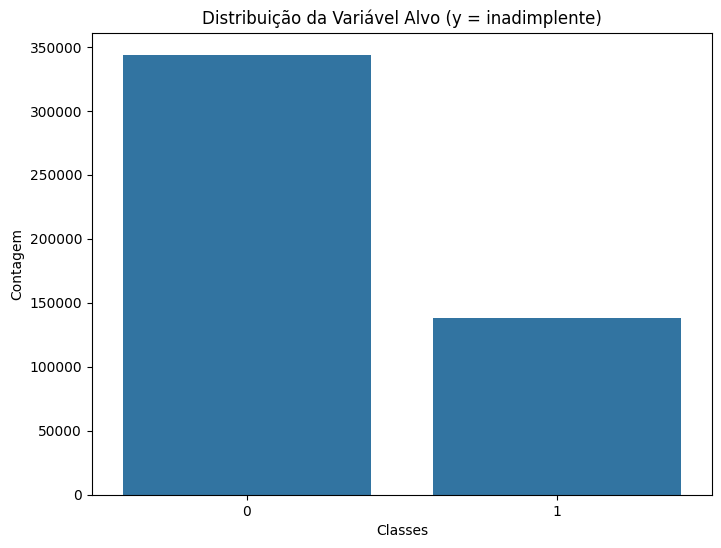

In [296]:
# Distribuição do y
pyplot.figure(figsize=(8, 6))
y = src_data[target]
seaborn.countplot(x=y)
pyplot.title('Distribuição da Variável Alvo (y = inadimplente)')
pyplot.xlabel('Classes')
pyplot.ylabel('Contagem')
pyplot.show()

<Figure size 1200x800 with 0 Axes>

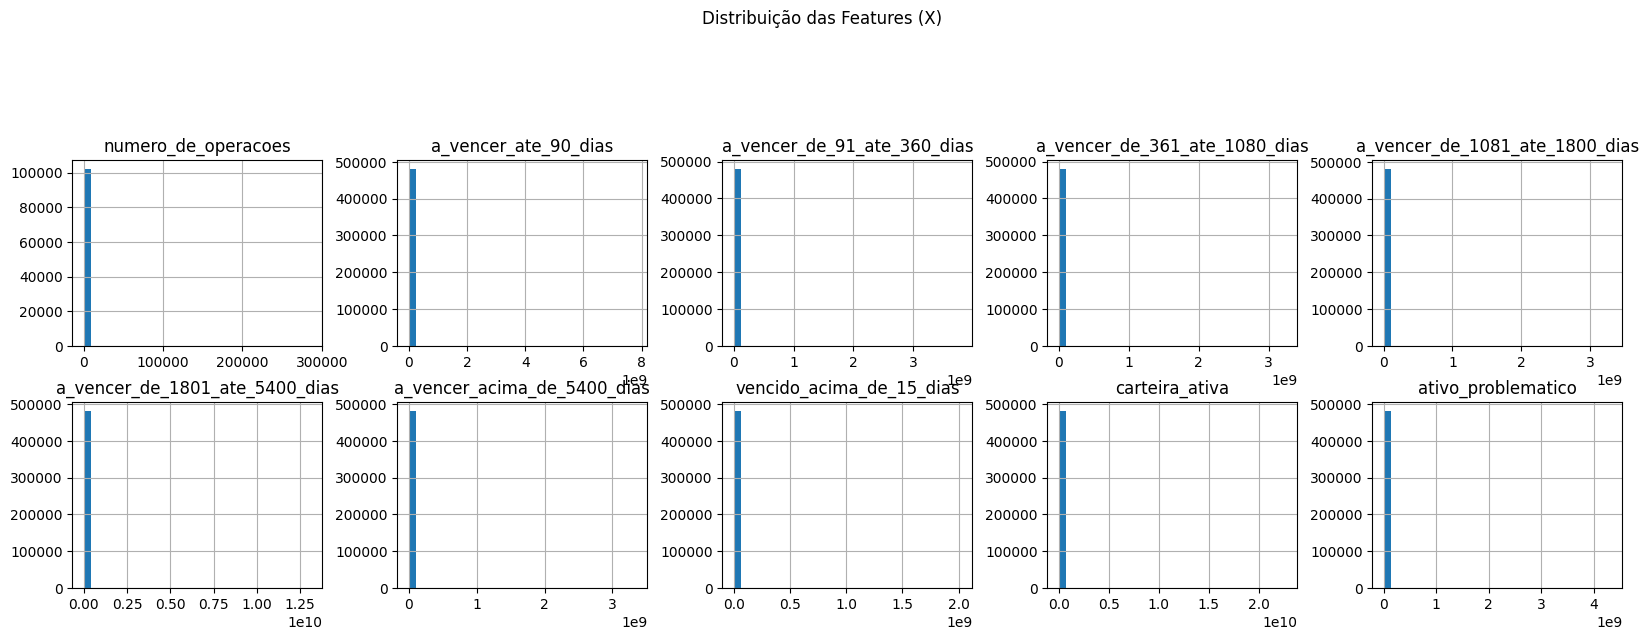

In [297]:
# Selecionar as features e o target
# Excluir as colunas inadimplente e carteira_inadimplida_arrastada das features de X
X = src_data.drop([target,'carteira_inadimplida_arrastada'], axis=1)

# Distribuição do X
pyplot.figure(figsize=(12, 8))
X.hist(bins=30, figsize=(20, 15), layout=(5, 5))
pyplot.suptitle('Distribuição das Features (X)')
pyplot.show()

In [298]:
# Balanço das Classes
class_balance = y.value_counts(normalize=True)
print("Balanço das Classes:")
print(class_balance)

Balanço das Classes:
inadimplente
0    0.713909
1    0.286091
Name: proportion, dtype: float64


In [252]:
# Correlação das variáveis categóricas com o target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dicionário para armazenar os resultados
chi2_results = {}

for feature in categorical_features:
    X_cat = src_data[feature].astype(str)
    X_cat_encoded = label_encoder.fit_transform(X_cat)
    chi2_val, p_val = chi2(X_cat_encoded.reshape(-1, 1), y_encoded)
    chi2_results[feature] = chi2_val[0]
    print(f"{feature} - chi2: {chi2_val[0]:.6f}, p-value: {p_val[0]:.6f}")

# Ordenar as variáveis com base nos valores de chi2
sorted_features = sorted(chi2_results, key=chi2_results.get, reverse=True)

# Selecionar as 3 variáveis mais relevantes
most_relevant_categorical_features = sorted_features[:3]

# Salvar as 4 variáveis mais relevantes numa variável e imprimir
print("\nAs 3 variáveis categóricas mais relevantes:")
for feature in most_relevant_categorical_features:
    print(f"{feature} - chi2: {chi2_results[feature]:.6f}")


uf - chi2: 554.399757, p-value: 0.000000
tcb - chi2: 2749.944216, p-value: 0.000000
sr - chi2: 22609.058384, p-value: 0.000000
ocupacao - chi2: nan, p-value: nan
cnae_secao - chi2: 1712.565693, p-value: 0.000000
cnae_subclasse - chi2: 1746.740238, p-value: 0.000000
porte - chi2: 1447.752624, p-value: 0.000000
modalidade - chi2: 119.348635, p-value: 0.000000
origem - chi2: 576.508766, p-value: 0.000000
indexador - chi2: 4352.777994, p-value: 0.000000

As 3 variáveis categóricas mais relevantes:
sr - chi2: 22609.058384
tcb - chi2: 2749.944216
ocupacao - chi2: nan


Correlação de Pearson (em percentual):
a_vencer_ate_90_dias                2.796172
a_vencer_de_91_ate_360_dias         3.981535
a_vencer_de_361_ate_1080_dias       6.033766
a_vencer_de_1081_ate_1800_dias      1.565799
a_vencer_de_1801_ate_5400_dias      0.168324
a_vencer_acima_de_5400_dias        -0.019874
vencido_acima_de_15_dias           96.105280
carteira_ativa                      6.642322
carteira_inadimplida_arrastada    100.000000
ativo_problematico                 22.365865
numero_de_operacoes                 4.026574
Name: carteira_inadimplida_arrastada, dtype: float64


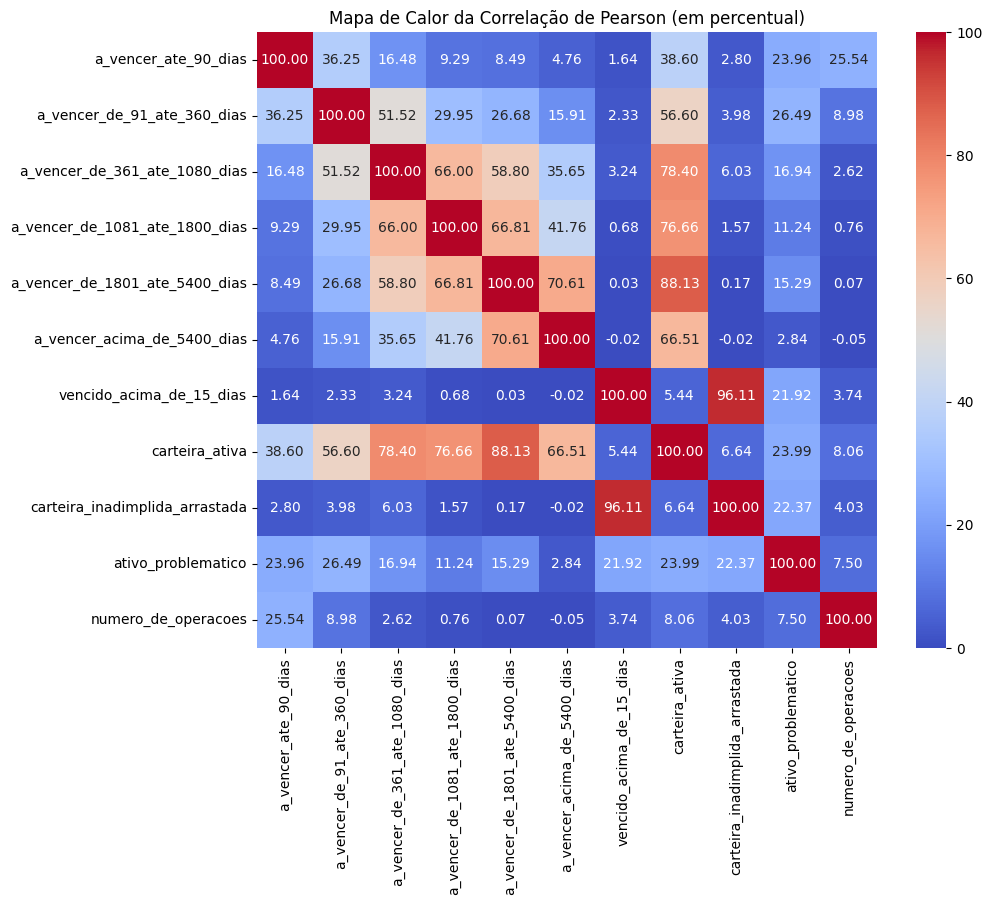


As 4 variáveis numéricas mais relevantes (em percentual):
vencido_acima_de_15_dias - correlação: 96.11%
ativo_problematico - correlação: 22.37%
carteira_ativa - correlação: 6.64%
a_vencer_de_361_ate_1080_dias - correlação: 6.03%


In [253]:
# Calculo das correlações de Pearson
correlacoes_pearson = src_data[numerical_features].corr(method='pearson')

# Converter correlações para percentual
correlacoes_pearson_percentual = correlacoes_pearson * 100

# Imprimir correlações em percentual
print("Correlação de Pearson (em percentual):")
print(correlacoes_pearson_percentual['carteira_inadimplida_arrastada'])

# Visualização com Heatmap
pyplot.figure(figsize=(10, 8))
seaborn.heatmap(correlacoes_pearson_percentual, annot=True, cmap='coolwarm', fmt='.2f')
pyplot.title('Mapa de Calor da Correlação de Pearson (em percentual)')
pyplot.show()

# Analisar as 4 variáveis mais relevantes
correlation_values = correlacoes_pearson_percentual['carteira_inadimplida_arrastada'].abs().sort_values(ascending=False)
top_4_features = correlation_values.index[1:5]  # Ignorar a primeira que é a própria 'carteira_inadimplida_arrastada'

# Salvar as 4 variáveis mais relevantes numa variável e imprimir
most_relevant_numerical_features = top_4_features.tolist()
print("\nAs 4 variáveis numéricas mais relevantes (em percentual):")
for feature in most_relevant_numerical_features:
    print(f"{feature} - correlação: {correlacoes_pearson_percentual.at[feature, 'carteira_inadimplida_arrastada']:.2f}%")

In [64]:
# Calculo das correlações de Spearman
correlacoes_spearman = src_data.corr(method='spearman')
print("Correlação de Spearman:")
print(correlacoes_spearman['carteira_inadimplida_arrastada'])  

pyplot.figure(figsize=(10, 8))
seaborn.heatmap(correlacoes_pearson, annot=True, cmap='coolwarm', fmt='.2f')
pyplot.title('Mapa de Calor da Correlação de Pearson')
pyplot.show()

Correlações com o target 'inadimplente':
inadimplente - a_vencer_ate_90_dias = 0.040632
inadimplente - a_vencer_de_91_ate_360_dias = 0.039793
inadimplente - a_vencer_de_361_ate_1080_dias = 0.049845
inadimplente - a_vencer_de_1081_ate_1800_dias = 0.033209
inadimplente - a_vencer_de_1801_ate_5400_dias = 0.017706
inadimplente - a_vencer_acima_de_5400_dias = 0.013800
inadimplente - vencido_acima_de_15_dias = 0.061798
inadimplente - carteira_ativa = 0.042410
inadimplente - carteira_inadimplida_arrastada = 0.078144
inadimplente - ativo_problematico = 0.041884
inadimplente - numero_de_operacoes = 0.038168


In [299]:
# 5. Análise de Importância de Features
X = src_data[numerical_features + categorical_features]
y = src_data[target]

# Codificar as features categóricas
#X_encoded = pd.get_dummies(X, drop_first=True)

# Treinar um modelo de RandomForest
model = RandomForestRegressor()
model.fit(X, y)

# Obter a importância das features
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Imprimir a importância das features
print("Importância das Features:")
for feature, importance in feature_importances.items():
    print(f"{feature} = {importance:.6f}")

# 6. Análise de Correlação das Features Categóricas com o Target
print(f"Relação das features categóricas com o target '{target}':")

ValueError: operands could not be broadcast together with shapes (11,) (10,) 

In [254]:
# Seleção das variáveis numéricas e categóricas que serão usadas no treinamento

# Combine as listas de variáveis numéricas e categóricas
selected_features = most_relevant_categorical_features + most_relevant_numerical_features

# Filtrar o DataFrame para manter apenas as colunas selecionadas
X = src_data[selected_features]
y = src_data[target]

# Imprimir as colunas selecionadas
print("Colunas selecionadas:")
print(X.columns.tolist())

Colunas selecionadas:
['sr', 'tcb', 'ocupacao', 'vencido_acima_de_15_dias', 'ativo_problematico', 'carteira_ativa', 'a_vencer_de_361_ate_1080_dias']


In [255]:
# Codificação das variáveis categóricas
X = pd.get_dummies(X, columns=most_relevant_categorical_features)

In [256]:
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [285]:
# Construção do modelo de rede neural
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\projects\python\infnet\trabalho\data_sets\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [258]:
#Definição da função de perda e o otimizador
match optimizer_name:
            case 'sgd':
                optimizer = keras.optimizers.SGD(learning_rate=learning_rate_defined)
            case 'adam':
                optimizer = keras.optimizers.Adam(learning_rate=learning_rate_defined)
            case 'rmsprop':
                optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate_defined)
            case _:
                raise ValueError(f'Optimizer {optimizer_name} not recognized')

In [259]:
# Compilação do modelo
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics_defined)

In [260]:
# Definição doo callback de Early Stopping
early_stopping = EarlyStopping(monitor=monitor_metric, 
                               patience=early_stopping_patience, 
                               mode=early_stopping_mode, 
                               verbose=verbosity)

In [286]:
# Treino do modelo com Early Stopping
history = model.fit(X_train, 
          y_train, 
          epochs=num_epochs, 
          batch_size=train_batch_size, 
          verbose=verbosity, 
          validation_split=validation_split_ratio, 
          callbacks=[early_stopping])

ValueError: You must call `compile()` before using the model.

In [274]:
# Fazer previsões
y_pred = model.predict(X_test)

# Converter previsões contínuas em rótulos binários
y_pred = (y_pred > 0.5).astype(int)

3011/3011 ━━━━━━━━━━━━━━━━━━━━ 2s 547us/step


In [275]:
# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')

# Imprimir a quantidade de valores classificados como inadimplentes e adimplentes
inadimplentes = np.sum(y_pred)
adimplentes = len(y_pred) - inadimplentes
print(f'Inadimplentes: {inadimplentes}')
print(f'Adimplentes: {adimplentes}')

# Imprimir o relatório de classificação
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

Acurácia: 0.92
Inadimplentes: 29238
Adimplentes: 67107
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     68551
           1       0.85      0.90      0.87     27794

    accuracy                           0.92     96345
   macro avg       0.90      0.92      0.91     96345
weighted avg       0.93      0.92      0.93     96345



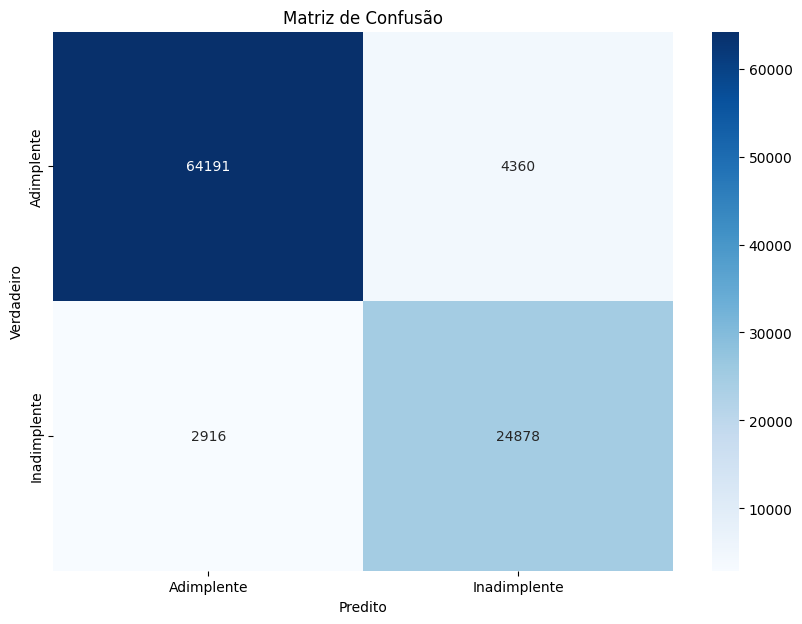

In [276]:
# Plotar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
pyplot.figure(figsize=(10, 7))
seaborn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Adimplente', 'Inadimplente'], yticklabels=['Adimplente', 'Inadimplente'])
pyplot.xlabel('Predito')
pyplot.ylabel('Verdadeiro')
pyplot.title('Matriz de Confusão')
pyplot.show()

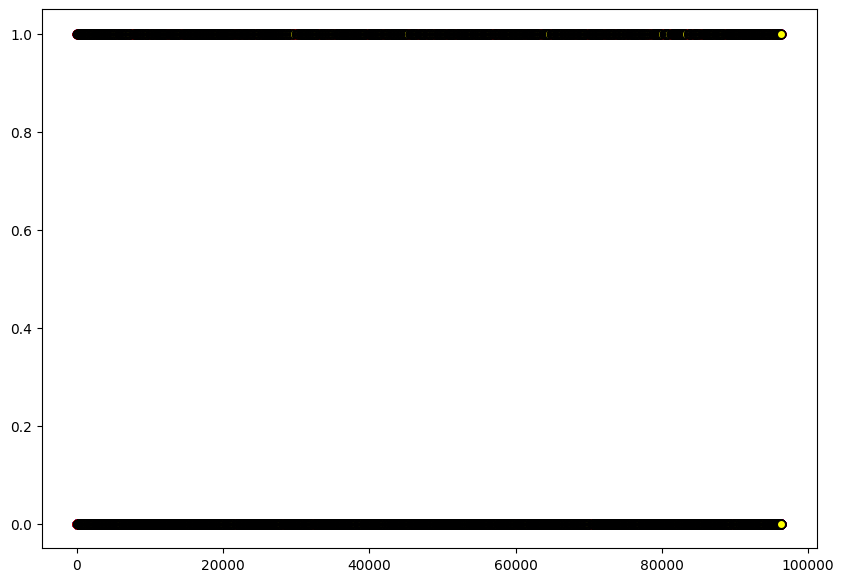

In [277]:
# Plotar gráfico de dispersão para visualizar os erros e acertos
pyplot.figure(figsize=(10, 7))
pyplot.scatter(range(len(y_test)), y_test, color='blue', label='Verdadeiro')
pyplot.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predito')

# Garantir que y_pred seja um array unidimensional
y_pred = np.squeeze(y_pred)

# Destacar os erros
errors = y_test != y_pred
pyplot.scatter(np.where(errors)[0], y_test[errors], color='yellow', edgecolor='black', label='Erros')

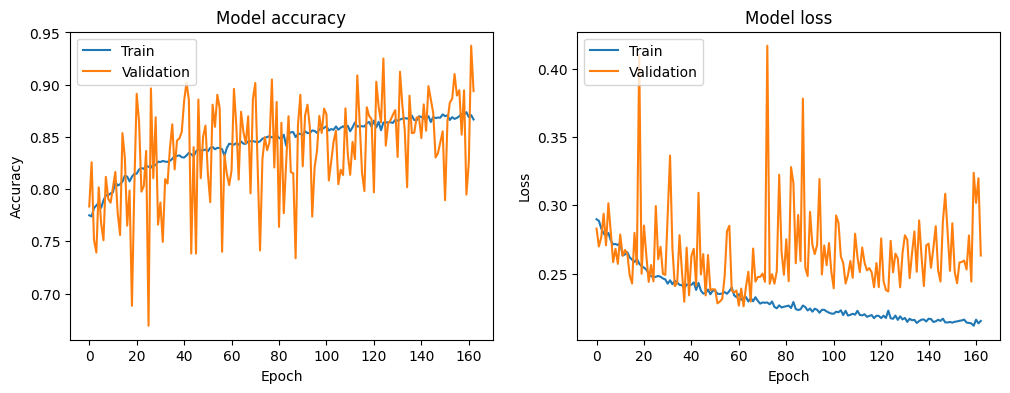

In [279]:
# Access the history attribute
history_dict = history.history

# Plot training & validation accuracy values
pyplot.figure(figsize=(12, 4))

pyplot.subplot(1, 2, 1)
pyplot.plot(history_dict['recall'])
pyplot.plot(history_dict['val_recall'])
pyplot.title('Model accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
pyplot.subplot(1, 2, 2)
pyplot.plot(history_dict['loss'])
pyplot.plot(history_dict['val_loss'])
pyplot.title('Model loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper left')

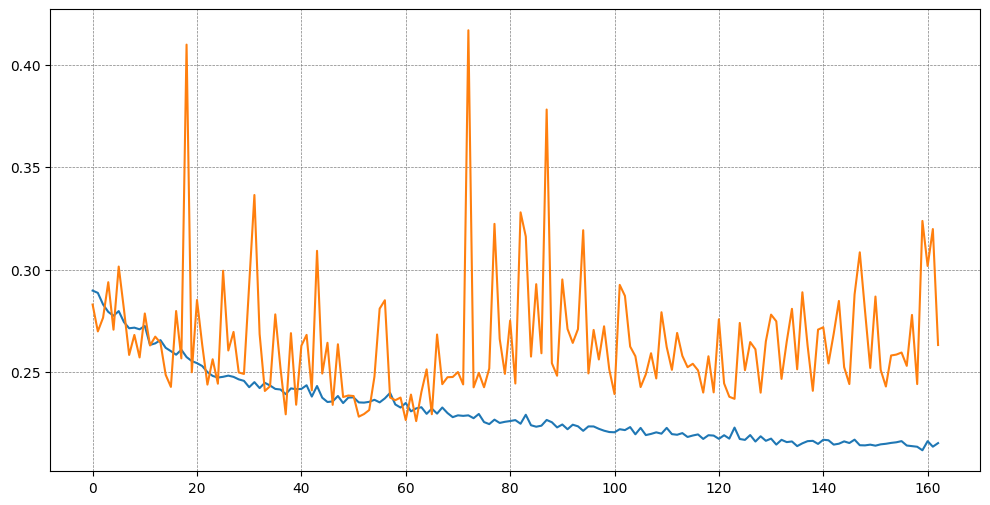

In [280]:
# PLOT TRAINING HISTORY
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(history_dict['loss'], label='loss')
_ = ax.plot(history_dict['val_loss'], label='val_loss')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

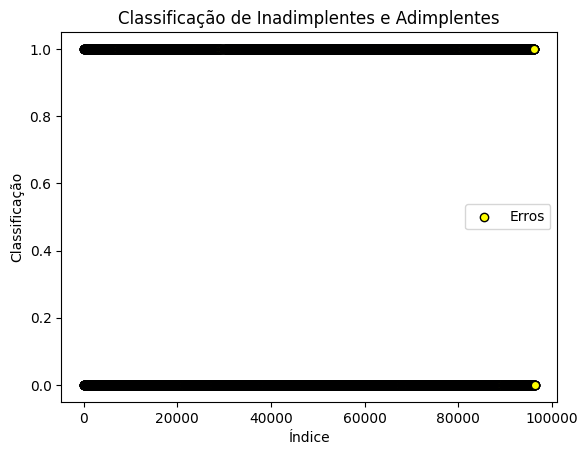

In [281]:
# Destacar os erros
errors = y_test != y_pred
pyplot.scatter(np.where(errors)[0], y_test[errors], color='yellow', edgecolor='black', label='Erros')

pyplot.xlabel('Índice')
pyplot.ylabel('Classificação')
pyplot.title('Classificação de Inadimplentes e Adimplentes')
pyplot.legend()
pyplot.show()

In [282]:
# Plotar gráficos de precisão e recall
classes = ['Adimplente', 'Inadimplente']
precision = [report[str(i)]['precision'] for i in range(2)]
recall = [report[str(i)]['recall'] for i in range(2)]

# Calcular o relatório de classificação
report = classification_report(y_test, y_pred, output_dict=True)

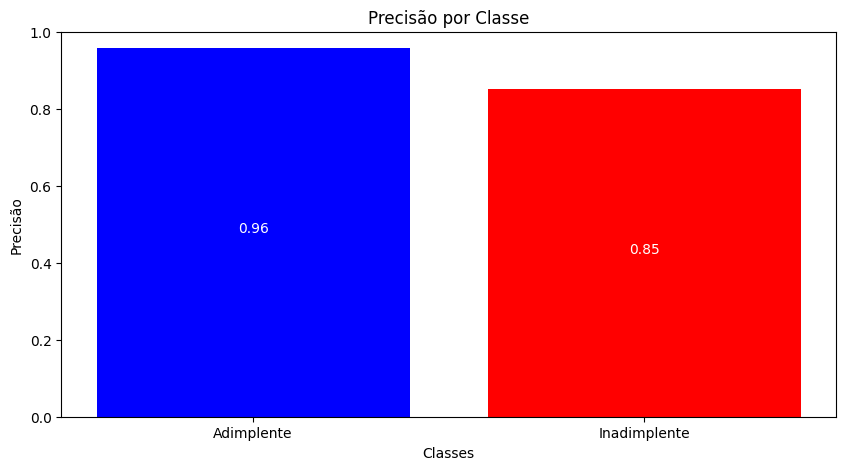

In [283]:
# Gráfico de Precisão
pyplot.figure(figsize=(10, 5))
pyplot.bar(classes, precision, color=['blue', 'red'])
pyplot.xlabel('Classes')
pyplot.ylabel('Precisão')
pyplot.title('Precisão por Classe')
pyplot.ylim(0, 1)
for i in range(len(classes)):
    pyplot.text(i, precision[i] / 2, f'{precision[i]:.2f}', ha='center', color='white')
pyplot.show()

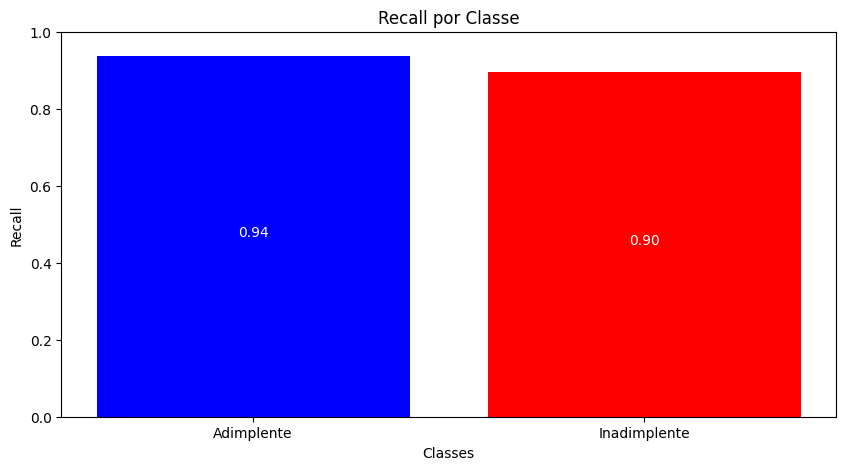

In [284]:
# Gráfico de Recall
pyplot.figure(figsize=(10, 5))
pyplot.bar(classes, recall, color=['blue', 'red'])
pyplot.xlabel('Classes')
pyplot.ylabel('Recall')
pyplot.title('Recall por Classe')
pyplot.ylim(0, 1)
for i in range(len(classes)):
    pyplot.text(i, recall[i] / 2, f'{recall[i]:.2f}', ha='center', color='white')
pyplot.show()

In [ ]:








# Plotar gráficos de precisão e recall
classes = ['Adimplente', 'Inadimplente']
precision = [report[str(i)]['precision'] for i in range(2)]
recall = [report[str(i)]['recall'] for i in range(2)]

# Gráfico de Precisão
pyplot.figure(figsize=(10, 5))
pyplot.bar(classes, precision, color=['blue', 'red'])
pyplot.xlabel('Classes')
pyplot.ylabel('Precisão')
pyplot.title('Precisão por Classe')
pyplot.ylim(0, 1)
for i in range(len(classes)):
    pyplot.text(i, precision[i] / 2, f'{precision[i]:.2f}', ha='center', color='white')
pyplot.show()

# Gráfico de Recall
pyplot.figure(figsize=(10, 5))
pyplot.bar(classes, recall, color=['blue', 'red'])
pyplot.xlabel('Classes')
pyplot.ylabel('Recall')
pyplot.title('Recall por Classe')
pyplot.ylim(0, 1)
for i in range(len(classes)):
    pyplot.text(i, recall[i] / 2, f'{recall[i]:.2f}', ha='center', color='white')
pyplot.show()

